# Trajectories by simple integration for advected waves and unadvected waves

In [1]:
import numpy as np
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import xsimlab as xs

In [2]:
#Main parameters
d2s=86400 #24h in s
h2s=3600  #1h in s
w2=2*2*np.pi/86400 #wave pulsation
km=1e3
dt=1*h2s # model step
L=100*km
k2=2*np.pi/L


## Classes

In [3]:
@xs.process
class Position:
    """Compute the evolution of positions"""

    p_vars = xs.group("p_vars")
    p = xs.variable(dims="a", intent="inout", description="positions of particules", attrs={"units": "m"})
    
    def run_step(self):
        self._delta_p = sum((x for x in self.p_vars))
        
    def finalize_step(self):
        self.p += self._delta_p #p(t+dt)


In [4]:
def analytical_velocity_advected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*(x-um*t))

def analytical_velocity_unadvected(t, x, um, uw, w, k):
    return (um + uw*np.cos(w*t-k*x))

@xs.process
class AnaVelocity:
    """Calculate velocity at t and in all positions.
    """
    
    # parameters
    um = xs.variable(description="uniform and constant flow amplitude", attrs={"units":"m/s"})
    uw = xs.variable(description="wave amplitude", attrs={"units":"m/s"})
    w = xs.variable(description="wave pulsation", attrs={"units":"s^-1"})
    
    k = xs.variable(description="wave number", attrs={"units":"m⁻1"})
    advected = xs.variable(description="advected wave", attrs={"units":"1"})#booléen
    
    # variables
    v = xs.variable(dims="a", intent="out", description="velocity of particules", attrs={"units": "m/s"})
    p = xs.foreign(Position, "p", intent="in")
    
    def velocity_func(self, *args):
        if self.advected:
            return analytical_velocity_advected(*args)
        else:
            return analytical_velocity_unadvected(*args)
        
    #INITIALISATION OF VELOCITY
    @xs.runtime(args="sim_start") #this way t is the beginning time of the simulation
    def initialize(self,t):
        self.v = self.velocity_func(t, self.p, self.um, self.uw, self.w, self.k)
    
    
    @xs.runtime(args=["step_start"])
    def run_step(self, t):
         self.v = self.velocity_func(t, self.p, self.um, self.uw, self.w, self.k)  # v(x(t),t)
        
        
    #CALCULATION OF VELOCITY AT t time and position p
    @xs.runtime(args=["step_end"])
    def finalize_step(self, t):
        self.v = self.velocity_func(t, self.p, self.um, self.uw, self.w, self.k)  # v(x(t+dt),t+dt)
        
    

In [5]:
@xs.process
class InitPRegular:
    """Initialize `positions` profile with N regular values in a giving an interval."""

    mini = xs.variable(description="minimum for initial position", static=True)
    maxi = xs.variable(description="maximum for initial position", static=True)
    N = xs.variable(description="number of particules", static=True)
    
    a = xs.index(dims="a")

    p = xs.foreign(Position, "p", intent="out")
    
    def initialize(self):
        self.a = np.linspace(self.mini, self.maxi, self.N)
        self.p = self.a.copy()


In [6]:
@xs.process
class Euler:
    """Calculate positions at t+dt using Euler method.
"""
    p_advected = xs.variable(dims="a", intent="out", groups="p_vars")
    v = xs.foreign(AnaVelocity, "v", intent="in")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.p_advected = self.v*dt #self.v=v(x,t)

In [7]:
@xs.process
class Runge_Kutta2:
    """Calculate positions at t+dt using Runge-Kutta method of order 2.
"""
    p_advected = xs.variable(dims="a", intent="out", groups="p_vars")

    v = xs.foreign(AnaVelocity, "v", intent="in")
    p = xs.foreign(Position, "p", intent="in")
    
    #parameters
    advected = xs.foreign(AnaVelocity, "advected", intent="in")
    um = xs.foreign(AnaVelocity, "um")
    uw = xs.foreign(AnaVelocity, "uw")
    w = xs.foreign(AnaVelocity, "w")
    k = xs.foreign(AnaVelocity, "k")
    
    def velocity_func(self, *args):
        if self.advected:
            return analytical_velocity_advected(*args)
        else:
            return analytical_velocity_unadvected(*args)
    
    @xs.runtime(args=["step_delta", "step_start"])
    def run_step(self, dt,t):
        self._p1 =self.p + self.v*dt
        self.p_advected = dt/2*(self.v + self.velocity_func(t, self._p1, self.um, self.uw, self.w, self.k))

In [8]:
@xs.process
class Runge_Kutta4:
    """Calculate positions at t+dt using Runge-Kutta method of order 4.
"""
    p_advected = xs.variable(dims="a", intent="out", groups="p_vars")

    v = xs.foreign(AnaVelocity, "v", intent="in")
    p = xs.foreign(Position, "p", intent="in")
    
    #parameters
    advected = xs.foreign(AnaVelocity, "advected", intent="in")
    um = xs.foreign(AnaVelocity, "um")
    uw = xs.foreign(AnaVelocity, "uw")
    w = xs.foreign(AnaVelocity, "w")
    k = xs.foreign(AnaVelocity, "k")

    def velocity_func(self, *args):
        if self.advected:
            return analytical_velocity_advected(*args)
        else:
            return analytical_velocity_unadvected(*args)
    
    @xs.runtime(args=["step_delta", "step_start"])
    def run_step(self, dt,t):
        
        t2=t+dt/2

        self._p1 = self.p + dt/2 * self.v
        self._v1 = self.velocity_func(t2, self._p1, self.um, self.uw, self.w, self.k)# v(p1, t+dt/2)
        
        self._p2 = self.p + dt/2 * self._v1 
        self._v2 = self.velocity_func(t2, self._p2, self.um, self.uw, self.w, self.k)# v(p2, t+dt/2)
        
        self._p3 = self.p + dt * self._v2
        self._v3 = self.velocity_func(t+dt, self._p3, self.um, self.uw, self.w, self.k)# v(p3, t+dt)
        
        
        self.p_advected = dt/6 *( self.v + 2*self._v2 + self._v3 + 2*self._v1)
        

In [9]:
class SetUp:
    def __init__(self,
                 intmethod=Euler,
                 init_p=InitPRegular,
                 time= list(np.arange(0,d2s*4, h2s/2)),
                 otime=list(np.arange(0, d2s*4, h2s)),
                 init_mini=0, init_maxi=200*km, init_N=100,
                 um=0.1, uw=0.1, w=w2, k=k2, advected=1):

        self.model= xs.Model({
            "position": Position,
            "init": init_p,
            "intmethod": intmethod,
            "velocity": AnaVelocity
        })
        self.in_ds=xs.create_setup(model=self.model,
                            clocks={'time': time,
                                    'otime': otime}, 
                        master_clock='time',
                        input_vars={'init': {'mini': init_mini, 'maxi':init_maxi, 'N':init_N},
                                    'velocity': {'um': um, 'uw': uw, 'w':w, 'k':k, 'advected':advected},
                                    },
                        output_vars={'position__p' : 'otime','velocity__v' : 'otime'})
        self.out_ds=self.in_ds.xsimlab.run(model=self.model)
        
        
    def update_model(self,**process):#update processes of the model ex: change Euler->Runge Kutta: **process = intmethod=Runge_Kutta2
        self.model = (self.model).update_processes(process)
        self.out_ds= self.in_ds.xsimlab.run(model=self.model)
            
    def update_parameters(self,**parameters):#change one or several parameters 
        self.in_ds = self.in_ds.xsimlab.update_vars(model=self.model, input_vars=parameters)
        self.out_ds= self.in_ds.xsimlab.run(model=self.model)
    
    def print_positions(self):#print positions trajectories
        self.out_ds.position__p.isel(a=slice(0,None,10)).plot(x="otime", hue="a", figsize=(9,9))
    
    def print_velocities(self):#print velocities for different otime
        fg=self.out_ds.isel(otime=slice(0,None,20)).plot.scatter(x="a", y="velocity__v", marker='.', s=10,col='otime')

    
    def analytical_comparison(self):#verify model respects the analytical solution
        if self.out_ds.velocity__advected:
            _va=analytical_velocity_advected(self.out_ds.otime, self.out_ds.position__p,self.out_ds.velocity__um, self.out_ds.velocity__uw, self.out_ds.velocity__w, self.out_ds.velocity__k)
        else:
            _va=analytical_velocity_unadvected(self.out_ds.otime, self.out_ds.position__p,self.out_ds.velocity__um, self.out_ds.velocity__uw, self.out_ds.velocity__w, self.out_ds.velocity__k)
        
        return np.all(_va==self.out_ds.velocity__v)     

In [10]:
x=SetUp()
x.update_parameters(velocity__um=0.2, velocity__uw=0.1)
x.out_ds

<xarray.Dataset>
Dimensions:             (a: 100, otime: 96, time: 192)
Coordinates:
  * a                   (a) float64 0.0 2.02e+03 4.04e+03 ... 1.98e+05 2e+05
  * otime               (otime) int64 0 3600 7200 10800 ... 334800 338400 342000
  * time                (time) float64 0.0 1.8e+03 ... 3.42e+05 3.438e+05
Data variables:
    init__N             int64 100
    init__maxi          float64 2e+05
    init__mini          int64 0
    position__p         (otime, a) float64 0.0 2.02e+03 ... 2.667e+05 2.688e+05
    velocity__advected  int64 1
    velocity__k         float64 6.283e-05
    velocity__um        float64 0.2
    velocity__uw        float64 0.1
    velocity__v         (otime, a) float64 0.3 0.2992 0.2968 ... 0.2913 0.2854
    velocity__w         float64 0.0001454

In [11]:
x.analytical_comparison()

<xarray.DataArray ()>
array(True)

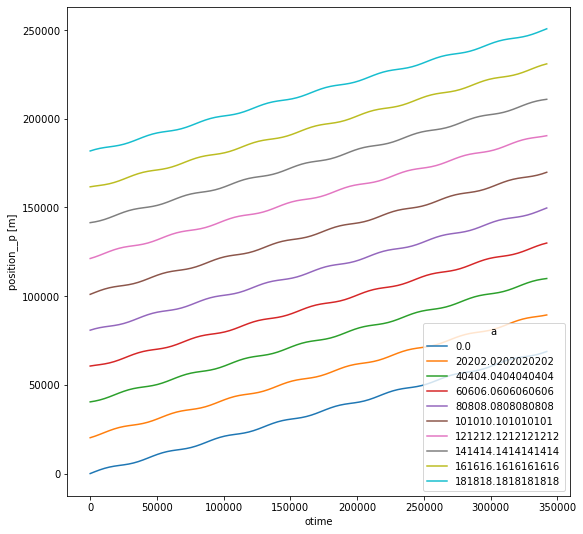

In [12]:
x.print_positions()

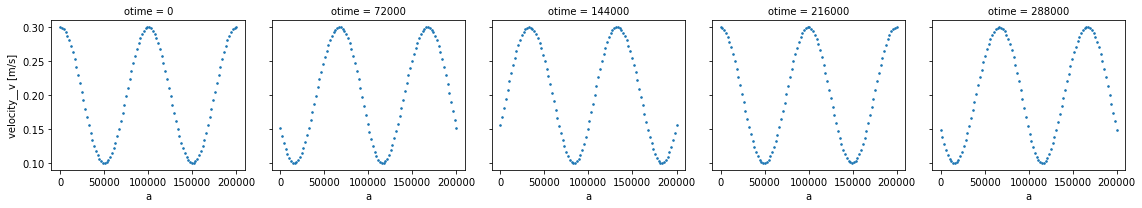

In [13]:
x.print_velocities()

In [ ]:
#fg=self.out_ds.isel(otime=slice(0,None,20)).plot.scatter(x="a", y="position__p", marker='.', s=10,col='otime')
#    for ax in fg.axes[0]:
#        self.out_ds.isel(otime=0).plot.scatter(x="a", y="position__p", marker='.', c='red', s=1, ax=ax)